**Sources:**

https://medium.com/nerd-for-tech/building-an-object-detector-in-tensorflow-using-bounding-box-regression-2bc13992973f

https://www.tensorflow.org/tutorials/images/transfer_learning


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
imageWidth = 224
imageHeight = 224
initialEpochs = 10

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

image_classes = ["Bee", "Fruit", "Seafood"]

zip_ref = zipfile.ZipFile("/content/drive/My Drive/OID.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()
dataSetLoc = '/tmp/OID/Dataset'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os as os
import pandas as pd
import cv2

xx = [] # images
yy = [] # labels
zz = [] # train targets

for image_class in image_classes:
  location = os.listdir(dataSetLoc + '/train/'+ image_class + '/Label')
  counter = 0
  for filename in location:
    if counter > 900:
      break
    counter = counter + 1
    fileNameSize = len(filename)
    imageLoc = dataSetLoc + '/train/'+ image_class + '/' +  filename[:fileNameSize - 3]  +'jpg' 
    loc = dataSetLoc + '/train/'+ image_class + '/Label' + '/' + filename
    notefile = pd.read_csv(loc,delim_whitespace=True, names=["class", "x0", "y0", "x1", "y1"])
    im = cv2.imread(imageLoc)
    height, width, channels = im.shape
    imS = cv2.resize(im, (imageWidth, imageHeight))  
    xx.append(imS)
    x0 = round(notefile["x0"][0] / width, 2)
    y0 = round(notefile["y0"][0] / height, 2)
    x1 = round(notefile["x1"][0] / width, 2)
    y1 = round(notefile["y1"][0] / height, 2)
    zz.append((x0, y0, x1, y1))
    yy.append(image_class)


In [ ]:
import numpy as np
X = np.array(xx)
y = np.array(yy)
z = np.array(zz)

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y= to_categorical(labelencoder.fit_transform(y))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test,z_train,z_test = train_test_split(X,y,z,test_size=0.2,random_state=1)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (imageHeight, imageWidth)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
trainTargets = {
    "cl_head": y_train,
    "bb_head": z_train
}
validationTargets = {
    "cl_head": y_test,
    "bb_head": z_test
}

y_test.shape

(541, 3)

In [ ]:
input_layer = tf.keras.Input(shape=(imageHeight, imageWidth, 3))
# x = data_augmentation(input_layer)
x = preprocess_input(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
base_layers = tf.keras.layers.Dropout(0.2)(x) 

In [ ]:
# locator_branch = tf.keras.layers.Flatten()()
locator_branch = tf.keras.layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = tf.keras.layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = tf.keras.layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = tf.keras.layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [ ]:
classifier_branch = tf.keras.layers.Flatten()(base_layers)
classifier_branch = tf.keras.layers.Dense(256,  name='cl_1', activation="relu")(classifier_branch)
classifier_branch = tf.keras.layers.Dense(len(image_classes), name='cl_head', activation='softmax')(classifier_branch)


In [ ]:

model = tf.keras.Model(input_layer,  outputs=[classifier_branch,locator_branch])

In [ ]:
losses = {
   "cl_head":tf.keras.losses.CategoricalCrossentropy(), 
   "bb_head":tf.keras.losses.MSE}

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=losses,
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_3 (TFOpLambda)  (None, 224, 224, 3)  0          ['input_7[0][0]']                
                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 224, 224, 3)  0          ['tf.math.truediv_3[0][0]']      
 )                                                                                                
                                                                                            

In [ ]:
trainTargets = {
    "cl_head": y_train,
    "bb_head": z_train
}
validationTargets = {
    "cl_head": y_test,
    "bb_head": z_test
}

In [ ]:
len(model.trainable_variables)

12

In [ ]:
test_accuracy=model.evaluate(X_test,validationTargets,verbose=0)
print(test_accuracy)

[2.0475354194641113, 1.828235387802124, 0.21930035948753357, 0.31792977452278137, 0.3173277676105499, 0.28096118569374084, 0.0018484288593754172, 0.9255813956260681, 0.4851292073726654]


In [ ]:
initial_epochs = 10
history = model.fit(X_train, trainTargets,
                    epochs=initial_epochs,
                    validation_data=(X_test, validationTargets))

Epoch 1/10
68/68 [==============================] - 13s 131ms/step - loss: 0.6274 - cl_head_loss: 0.5746 - bb_head_loss: 0.0528 - cl_head_accuracy: 0.8215 - cl_head_precision_6: 0.8276 - cl_head_recall_6: 0.8191 - bb_head_accuracy: 0.5375 - bb_head_precision_6: 0.9970 - bb_head_recall_6: 0.5407 - val_loss: 0.3223 - val_cl_head_loss: 0.2793 - val_bb_head_loss: 0.0430 - val_cl_head_accuracy: 0.9002 - val_cl_head_precision_6: 0.9048 - val_cl_head_recall_6: 0.8780 - val_bb_head_accuracy: 0.5601 - val_bb_head_precision_6: 0.9972 - val_bb_head_recall_6: 0.5202
Epoch 2/10
68/68 [==============================] - 8s 122ms/step - loss: 0.0977 - cl_head_loss: 0.0719 - bb_head_loss: 0.0257 - cl_head_accuracy: 0.9778 - cl_head_precision_6: 0.9787 - cl_head_recall_6: 0.9755 - bb_head_accuracy: 0.6216 - bb_head_precision_6: 0.9998 - bb_head_recall_6: 0.5354 - val_loss: 0.3670 - val_cl_head_loss: 0.3247 - val_bb_head_loss: 0.0424 - val_cl_head_accuracy: 0.8835 - val_cl_head_precision_6: 0.8864 - val_

### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
losses = {"cl_head":tf.keras.losses.CategoricalCrossentropy(), 
   "bb_head":tf.keras.losses.MSE}
model.compile(loss=losses,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
len(model.trainable_variables)

66

### Continue training the model

In [ ]:
fine_tune_epochs = 8
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(X_train, trainTargets,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1])

Epoch 10/18
68/68 [==============================] - 18s 158ms/step - loss: 0.0138 - cl_head_loss: 0.0102 - bb_head_loss: 0.0035 - cl_head_accuracy: 0.9991 - cl_head_precision_7: 0.9991 - cl_head_recall_7: 0.9986 - bb_head_accuracy: 0.8515 - bb_head_precision_7: 1.0000 - bb_head_recall_7: 0.5357
Epoch 11/18
68/68 [==============================] - 11s 157ms/step - loss: 0.0106 - cl_head_loss: 0.0078 - bb_head_loss: 0.0028 - cl_head_accuracy: 0.9986 - cl_head_precision_7: 0.9986 - cl_head_recall_7: 0.9986 - bb_head_accuracy: 0.8538 - bb_head_precision_7: 1.0000 - bb_head_recall_7: 0.5324
Epoch 12/18
68/68 [==============================] - 11s 156ms/step - loss: 0.0071 - cl_head_loss: 0.0047 - bb_head_loss: 0.0024 - cl_head_accuracy: 0.9991 - cl_head_precision_7: 0.9991 - cl_head_recall_7: 0.9991 - bb_head_accuracy: 0.8585 - bb_head_precision_7: 1.0000 - bb_head_recall_7: 0.5305
Epoch 13/18
68/68 [==============================] - 11s 156ms/step - loss: 0.0095 - cl_head_loss: 0.0073 - b

In [ ]:
test_results=model.evaluate(X_test,validationTargets,verbose=0)
print('classification accuracy ', test_results[2])
print('classification precision ', test_results[3])
print('classification recall ', test_results[4])
print('localisation accuracy ', test_results[5])
print('localisation precision ', test_results[6])
print('localisation recall ', test_results[7])

F1_classification = 2 * test_results[3] * test_results[4] / (test_results[3] + test_results[4])
print('F1_classification ', F1_classification)
F1_localisation = 2 * test_results[6] * test_results[7] / (test_results[6] + test_results[7])
print('F1_localisation ', F1_localisation)

classification accuracy  0.038756899535655975
classification precision  0.9001848697662354
classification recall  0.9001848697662354
localisation accuracy  0.9001848697662354
localisation precision  0.6358595490455627
localisation recall  0.999071478843689
F1_classification  0.9001848697662354
F1_localisation  0.7771204156813689


In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x0'] < bb1['x1']
    assert bb1['y0'] < bb1['y1']
    assert bb2['x0'] < bb2['x1']
    assert bb2['y0'] < bb2['y1']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x0'], bb2['x0'])
    y_top = max(bb1['y0'], bb2['y0'])
    x_right = min(bb1['x1'], bb2['x1'])
    y_bottom = min(bb1['y1'], bb2['y1'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x1'] - bb1['x0']) * (bb1['y1'] - bb1['y0'])
    bb2_area = (bb2['x1'] - bb2['x0']) * (bb2['y1'] - bb2['y0'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

0.7641662624389434


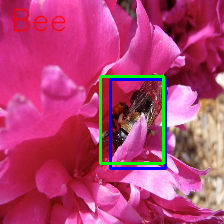

0.7557129774918436


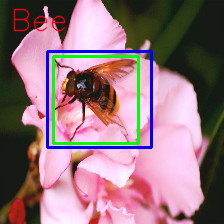

0.20157799709590715


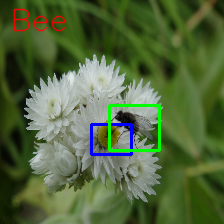

0.428219869726084


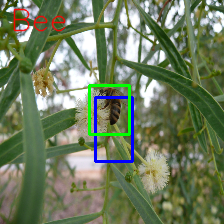

0.42557542119421277


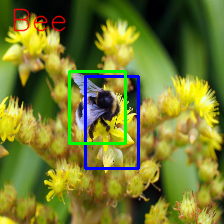

0.5271330122935036


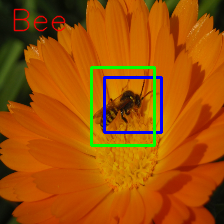

0.5895654050737985


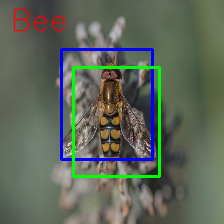

0.0


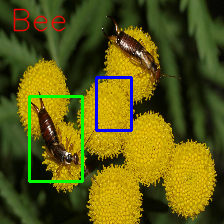

0.6539060332391392


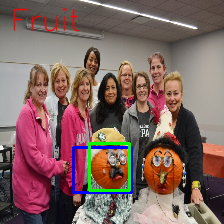

0.07397993458773387


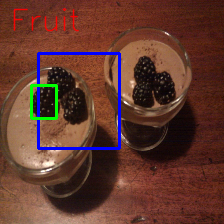

0.10264525354207112


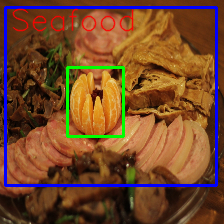

0.42867381151216105


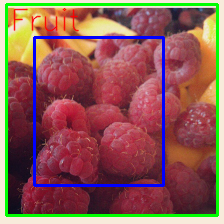

0.4247055988109805


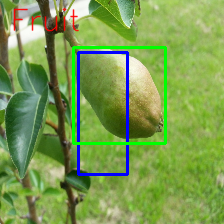

0.0


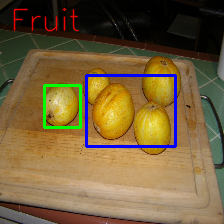

0.0


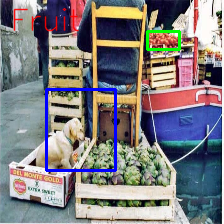

0.0


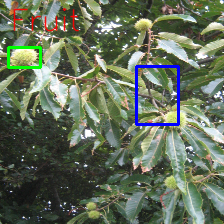

0.6857306833687081


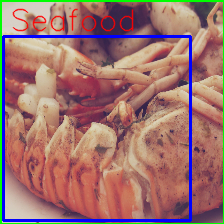

0.8141078939128297


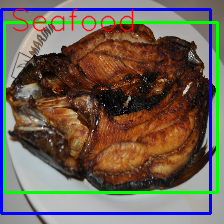

0.6740888172410469


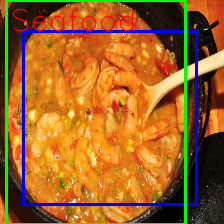

0.4537327701013198


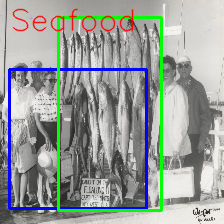

0.37680796760357643


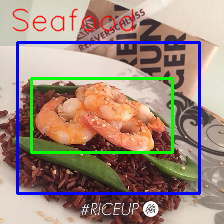

0.692201201819659


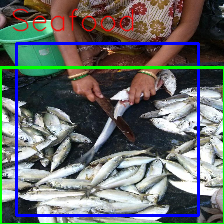

0.0


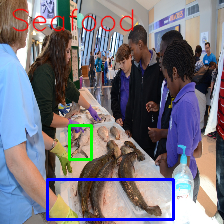

0.20063867837874416


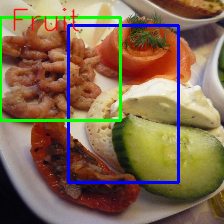

[[8 0 0]
 [0 7 1]
 [0 1 7]]
              precision    recall  f1-score   support

         Bee      1.000     1.000     1.000         8
       Fruit      0.875     0.875     0.875         8
     Seafood      0.875     0.875     0.875         8

    accuracy                          0.917        24
   macro avg      0.917     0.917     0.917        24
weighted avg      0.917     0.917     0.917        24



In [ ]:
from google.colab.patches import cv2_imshow
offset = 900
nrOfPics = 8

y_true = []
y_pred = []
loc_pred = []

from sklearn import metrics

for image_class in image_classes:
  location = os.listdir(dataSetLoc + '/train/'+ image_class + '/Label')
  counter = 0
  for filename in location[offset:offset+nrOfPics]:
    counter = counter + 1 
    fileNameSize = len(filename)
    imageLoc = dataSetLoc + '/train/'+ image_class + '/' +  filename[:fileNameSize - 3]  +'jpg' 
    loc = dataSetLoc + '/train/'+ image_class + '/Label' + '/' + filename
    notefile = pd.read_csv(loc,delim_whitespace=True, names=["class", "x0", "y0", "x1", "y1"])
    im = cv2.imread(imageLoc)
    height, width, channels = im.shape
    imS = cv2.resize(im, (imageWidth, imageHeight)) 
    inputArr = np.array([imS]) 
    prediction = model.predict(inputArr)
    
    x0 = int(prediction[1][0][0] * imageWidth)
    y0 = int(prediction[1][0][1] * imageHeight)
    x1 = int(prediction[1][0][2] * imageWidth)
    y1 = int(prediction[1][0][3] * imageHeight)
    box1 = {'x0': prediction[1][0][0], 'y0': prediction[1][0][1], 'x1': prediction[1][0][2], 'y1': prediction[1][0][3]}
    y_true.append(image_class)
    cv2.rectangle(imS, (x0,  y0), (x1, y1), (255,0,0), 2)

    
    x0 = int(round(notefile["x0"][0] / width, 2)*imageWidth)
    y0 = int(round(notefile["y0"][0] / height, 2)*imageHeight)
    x1 = int(round(notefile["x1"][0] / width, 2)*imageWidth)
    y1 = int(round(notefile["y1"][0] / height, 2)*imageHeight)
    box2 = {'x0': notefile["x0"][0] / width, 'y0': notefile["y0"][0] / height, 'x1': notefile["x1"][0] / width, 'y1': notefile["y1"][0] / height}
    iou = get_iou(box2, box1)
    loc_pred.append(iou)
    print(iou)
    cv2.rectangle(imS, (x0,  y0), (x1, y1), (0,255,0), 2)
    classes_x=np.argmax(prediction[0][0])
    predicted_class_str = labelencoder.inverse_transform([classes_x])
    text = predicted_class_str[0]
    y_pred.append(text)
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (10, 30)
    fontScale = 1
    color = (0, 0, 255)
    thickness = 1
    cv2.putText(imS, text, org, font, fontScale, color, thickness, cv2.LINE_AA, False)
    cv2_imshow(imS) 

cm = metrics.confusion_matrix(y_true, y_pred)
print(cm)
print(metrics.classification_report(y_true, y_pred, digits=3))

In [ ]:
fouls = [0, 0, 0]
for x in range(0, len(y_pred)-1, 1):
  if loc_pred[x] < 0.5 and y_pred[x] == y_true[x]:
    index = image_classes.index(y_pred[x])
    fouls[index] = fouls[index] + 1

print(fouls)

[4, 6, 3]


In [ ]:

for imageClass in image_classes:
  index = image_classes.index(imageClass)
  print(imageClass)
  TP = cm[index][index] 
  FP = sum(cm[index]) - TP
  FN = 0
  for x in range(0, len(image_classes)-1, 1):
    FN = cm[x][index] + FN
  TN = len(y_true) - TP - FP - FN
  TP = TP - fouls[index] 
  FP = FP + fouls[index] 

  acc = (TP + TN) / len(y_true)
  pre = TP / (TP + FP)
  rec = TP / (TP + FN)
  F1 = 2 * (pre*rec)/(pre+rec)
  print("acc ", acc)
  print("pre ", pre)
  print("rec ", rec)
  print("F1 ", F1)
  

Bee
acc  0.5
pre  0.5
rec  0.3333333333333333
F1  0.4
Fruit
acc  0.4166666666666667
pre  0.125
rec  0.125
F1  0.125
Seafood
acc  0.7916666666666666
pre  0.5
rec  0.8
F1  0.6153846153846154


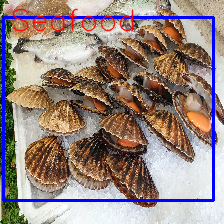

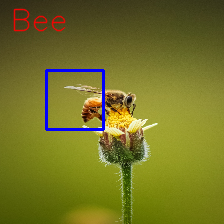

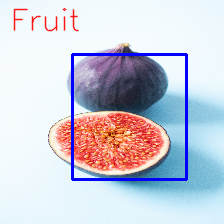

In [ ]:
  for filename in os.listdir('/tmp/lecturerTests'):
    imageLoc = '/tmp/lecturerTests/' + filename  
    im = cv2.imread(imageLoc)
    height, width, channels = im.shape
    imS = cv2.resize(im, (imageWidth, imageHeight)) 
    inputArr = np.array([imS]) 
    prediction = model.predict(inputArr)
    
    x0 = int(prediction[1][0][0] * imageWidth)
    y0 = int(prediction[1][0][1] * imageHeight)
    x1 = int(prediction[1][0][2] * imageWidth)
    y1 = int(prediction[1][0][3] * imageHeight)
    cv2.rectangle(imS, (x0,  y0), (x1, y1), (255,0,0), 2)
    classes_x=np.argmax(prediction[0][0])
    predicted_class_str = labelencoder.inverse_transform([classes_x])
    text = predicted_class_str[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (10, 30)
    fontScale = 1
    color = (0, 0, 255)
    thickness = 1
    cv2.putText(imS, text, org, font, fontScale, color, thickness, cv2.LINE_AA, False)
    cv2_imshow(imS) 